In [1]:
# Importamos librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Leemos los datos
data = pd.read_csv("200espiras.csv", usecols = [1, 2, 3])

In [3]:
# Pivot del dataframe para que cada espira tenga su propia columna
data_pivoted = data.pivot(columns = "Espira", values = "Intensidad", index = "FechaHora").reset_index()

In [5]:
# Buscamos espiras que tengan muchos valores consecutivos constantes
column_to_remove = []

for column in data_pivoted.columns:
    k = 1
    for i in range(1, len(data_pivoted)):
        if data_pivoted[column].iloc[i] == data_pivoted[column].iloc[i - 1]:
            k += 1
        else:
            k = 1
        if k > 100:
            column_to_remove.append(column)
            break

# Eliminamos dichas espiras
data_pivoted.drop(columns = column_to_remove, inplace = True)

In [6]:
# Buscamos espiras con varios nan seguidos
column_to_remove = []

for column in data_pivoted.columns:
    if data_pivoted[column].isna().any():
        column_to_remove.append(column)

# Eliminamos dichas espiras
data_pivoted.drop(columns = column_to_remove, inplace = True)

In [21]:
# Seleccionamos las espiras de estaciones y tetuan y exportamos a csv
data_pivoted.loc[:, [1014, 1046, 1047, 1050]].iloc[:-1, :].to_csv("Espiras_estaciones.csv")
data_pivoted.loc[:, [2034, 2035, 2036]].iloc[:-1, :].to_csv("Espiras_tetuan.csv")

In [7]:
# Transponemos el dataframe para tener las espiras en horizontal
data_for_clust = data_pivoted.transpose()

In [8]:
# Quitamos la fila de la fecha y la columna que corresponde a 1 de enero de 2024
data_for_clust = data_for_clust.iloc[1:, :-1]

In [8]:
import os

# Set the environment variable before importing scikit-learn
os.environ['OMP_NUM_THREADS'] = '1'

In [9]:
from sklearn.cluster import KMeans

# Probamos con todos los numeros posibles de clusters y guardamos la "inertia"
sse = []
for k in range(1, data_for_clust.shape[0]):
    kmeans = KMeans(n_clusters = k, random_state = 0, n_init = "auto")
    kmeans.fit(data_for_clust.values)
    sse.append(kmeans.inertia_)

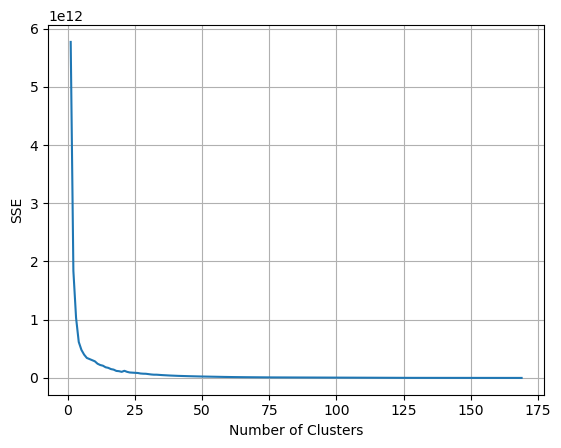

In [10]:
# Pintamos la inercia como funcion del numero de clusters
plt.plot(range(1, data_for_clust.shape[0]), sse)
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.grid(True)
plt.show(True)

In [11]:
from kneed import DataGenerator, KneeLocator

# Obtenemos el punto de estabilizacion de la curva -> n clusters optimo
kl = KneeLocator(range(1, data_for_clust.shape[0]), sse, curve = "convex", direction = "decreasing")
k_opt = kl.elbow

In [12]:
# Realizamos el clustering con el valor optimo
kmeans = KMeans(n_clusters = k_opt, random_state = 0, n_init = "auto")
kmeans.fit(data_for_clust.values)

KMeans(n_clusters=7, n_init='auto', random_state=0)

In [13]:
# Guardamos los centroides
traf_cent = kmeans.cluster_centers_

In [14]:
# Convertimos a dataframe.
traf_cent = pd.DataFrame(traf_cent)

In [17]:
# Transponemos para guardar como predictores
traf_cent = traf_cent.transpose()

# Exportamos
traf_cent.to_csv("Predictores_trafico.csv")